In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt


from utils.ode import hydrogen_bromine, hydrogen_bromine_init, map_equation

from utils.generators.generator import DataGenerator
from utils.generators.data import ODEDataGenerator

from models import WeightedLasso, DebiasedLasso

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


%load_ext autoreload
%autoreload 2

In [2]:
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12


dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
data_generator = DataGenerator().add_step(
    label="ode_data",
    step=ODEDataGenerator(
        equation=hydrogen_bromine,
        initial_state=hydrogen_bromine_init,
        t_span=t_train_span,
        random_state=42,
        **integrator_keywords,
    ),
)

X, y, theta = data_generator.generate(n_samples=t_train.shape[0], n_features=6)

print("Generated X shape:", X.shape)
print("t_train shape:", t_train.shape)

library = ps.PolynomialLibrary(degree=3)
library.fit(X)

true_parameters = map_equation(hydrogen_bromine, library)

model = ps.SINDy(
    feature_library=library,
    optimizer=DebiasedLasso(
        alpha=1e2, weights=(1 / (np.abs(true_parameters) + 1e-16)).T, max_iter=100_000_000, threshhold=1e3
    ),
    differentiation_method=ps.FiniteDifference(),
)

model.fit(x=X, t=t_train)
model.print()

# param_grid = {
#     "optimizer__alpha": np.logspace(-4, 4, 9),
#     "optimizer__weights": [
#         (1 / (np.abs(true_parameters) + 1e-12)).T,
#         (1 / (np.abs(true_parameters) + 1e-10)).T,
#         (1 / (np.abs(true_parameters) + 1e-8)).T,
#         (1 / (np.abs(true_parameters) + 1e-6)).T,
#         (1 / (np.abs(true_parameters) + 1e-4)).T,
#         (1 / (np.abs(true_parameters) + 1e-2)).T,
#     ],
#     "differentiation_method__order": [1, 2]
# }

# search = GridSearchCV(
#     model,
#     param_grid,
#     cv=TimeSeriesSplit(n_splits=5)
# )


# search.fit(X, t_train)

# print("Best parameters:", search.best_params_)
# search.best_estimator_.print()
# model = search.best_estimator_

Generated X shape: (5000, 6)
t_train shape: (5000,)
Problem 1/6 fitted.
Problem 2/6 fitted.
Problem 3/6 fitted.
Problem 4/6 fitted.
Problem 5/6 fitted.
(x0)' = -360484474190512.812 x0 x3 + -1248917806.121 x1 x4 + 2375477300894147.500 x1^2 x5 + 0.005 x3^3
(x1)' = 67660976738062.984 x0 x3 + 1253146.700 x0 x5 + -1530484687.326 x1 x2 + 1668277.490 x1 x4 + 7614207048417.461 x3 x4 + -3108755193303126.500 x1^2 x5 + -0.007 x3^3
(x2)' = -2607012749.556 x1 x2 + 13843950828995.797 x3 x4
(x3)' = 183328664281.258 x0 x3 + -4070995.507 x1 x2 + 21165872740.438 x3 x4
(x4)' = 35969300622315.711 x0 x3 + 4410636391.664 x1 x2 + -1924126.432 x1 x4 + -23319506137417.246 x3 x4
(x5)' = 0.000


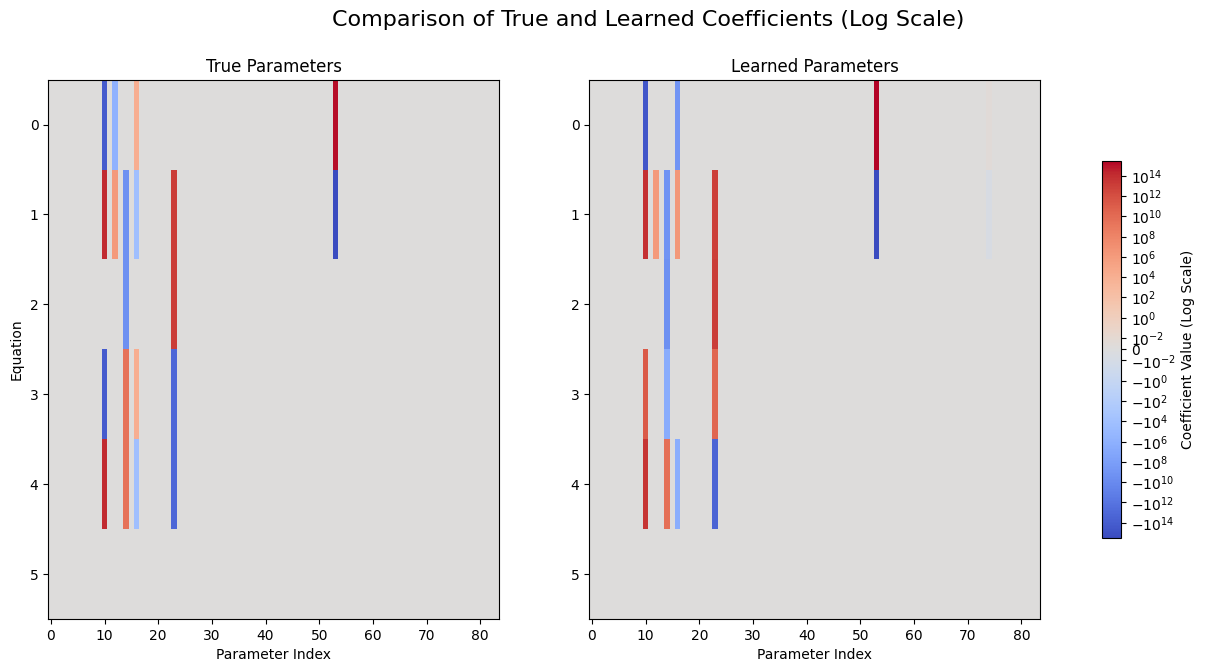

In [3]:
import matplotlib.colors as colors

learned_coefficients = model.coefficients()
# learned_coefficients[np.abs(learned_coefficients) < 1e-4] = 0.0
# true_parameters[np.abs(true_parameters) < 1e-4] = 0.0 # Also clean true params for fairness

# Reshape from 1D vector (100,) to 2D column vector (100, 1) for imshow
# true_params_2d = true_parameters.reshape(-1, 1)
# learned_coeffs_2d = learned_coefficients.reshape(-1, 1)


# --- 3. Set up Shared Color Scale ---
# Find the maximum absolute value across BOTH arrays to center the color map
abs_max = max(np.abs(true_parameters).max(), np.abs(learned_coefficients).max())

# Set vmin and vmax to be symmetric around zero.
vmin = -abs_max
vmax = abs_max

# Create the symmetric log normalizer
# linthresh: The range within which the plot is linear (-linthresh to +linthresh)
# A smaller value makes the log scale apply to smaller numbers.
linthresh = 1e-2
log_norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)


# --- 4. Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of True and Learned Coefficients (Log Scale)', fontsize=16)

# Plot True Parameters
im1 = ax[0].imshow(
    true_parameters,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the shared log normalization
)
ax[0].set_title('True Parameters')
ax[0].set_xlabel('Parameter Index')
ax[0].set_ylabel('Equation')
# ax[0].set_xticks([]) # Hide x-axis ticks as they are not meaningful

# Plot Learned Parameters
im2 = ax[1].imshow(
    learned_coefficients,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the SAME shared log normalization
)
ax[1].set_title('Learned Parameters')
ax[1].set_xlabel('Parameter Index')
# ax[1].set_xticks([])
# ax[1].set_yticks([]) # Hide y-axis ticks for the second plot

# Add a single, shared colorbar
fig.colorbar(im2, ax=ax, orientation='vertical', label='Coefficient Value (Log Scale)', shrink=0.7)

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

/tmp/nix-shell.DdVTmH/ipykernel_23910/3087476379.py:1: RuntimeWarning: divide by zero encountered in log10
  error = np.log10(np.abs(true_parameters - learned_coefficients))


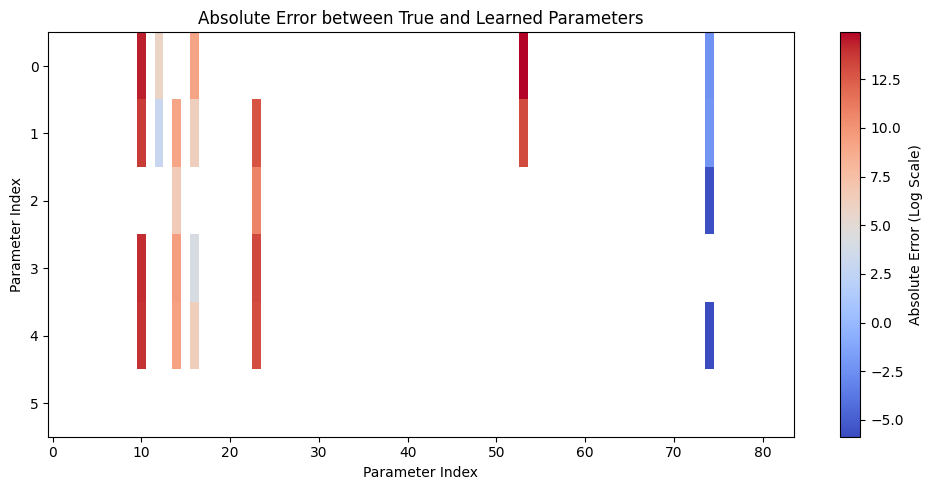

In [4]:
error = np.log10(np.abs(true_parameters - learned_coefficients))


# error = np.where(
#     np.abs(true_parameters) < 1e-4, 0.0, error
# )


plt.figure(figsize=(10, 5))
plt.imshow(
    error,
    aspect='auto',
    cmap='coolwarm',
)
plt.title('Absolute Error between True and Learned Parameters')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Index')
plt.colorbar(label='Absolute Error (Log Scale)')
plt.tight_layout()
plt.show()


In [5]:
true_parameters.shape, learned_coefficients.shape


((6, 84), (6, 84))

In [8]:
thresholded_coefficients = np.where(
    np.abs(learned_coefficients) < 1e-4, 0.0, learned_coefficients
)
model.coef_ = thresholded_coefficients

x_sim = model.simulate(hydrogen_bromine_init, t_train)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4434738844917D-02   r2 =  0.4175953311203D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4434738844917D-02   r2 =  0.4175953311203D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4434738844917D-02   r2 =  0.4175953311203D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4434738844917D-02   r2 =  0.4175953311203D-18
 lsoda--  warning..internal t (=r1) 

/home/jerry/Research/code/weight_perturbation/.venv/lib/python3.12/site-packages/pysindy/utils/axes.py:389: RuntimeWarning: overflow encountered in reduce
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/jerry/Research/code/weight_perturbation/.venv/lib/python3.12/site-packages/pysindy/utils/axes.py:389: RuntimeWarning: invalid value encountered in matmul
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/jerry/Research/code/weight_perturbation/.venv/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


ValueError: x and y must have same first dimension, but have shapes (5000,) and (3,)

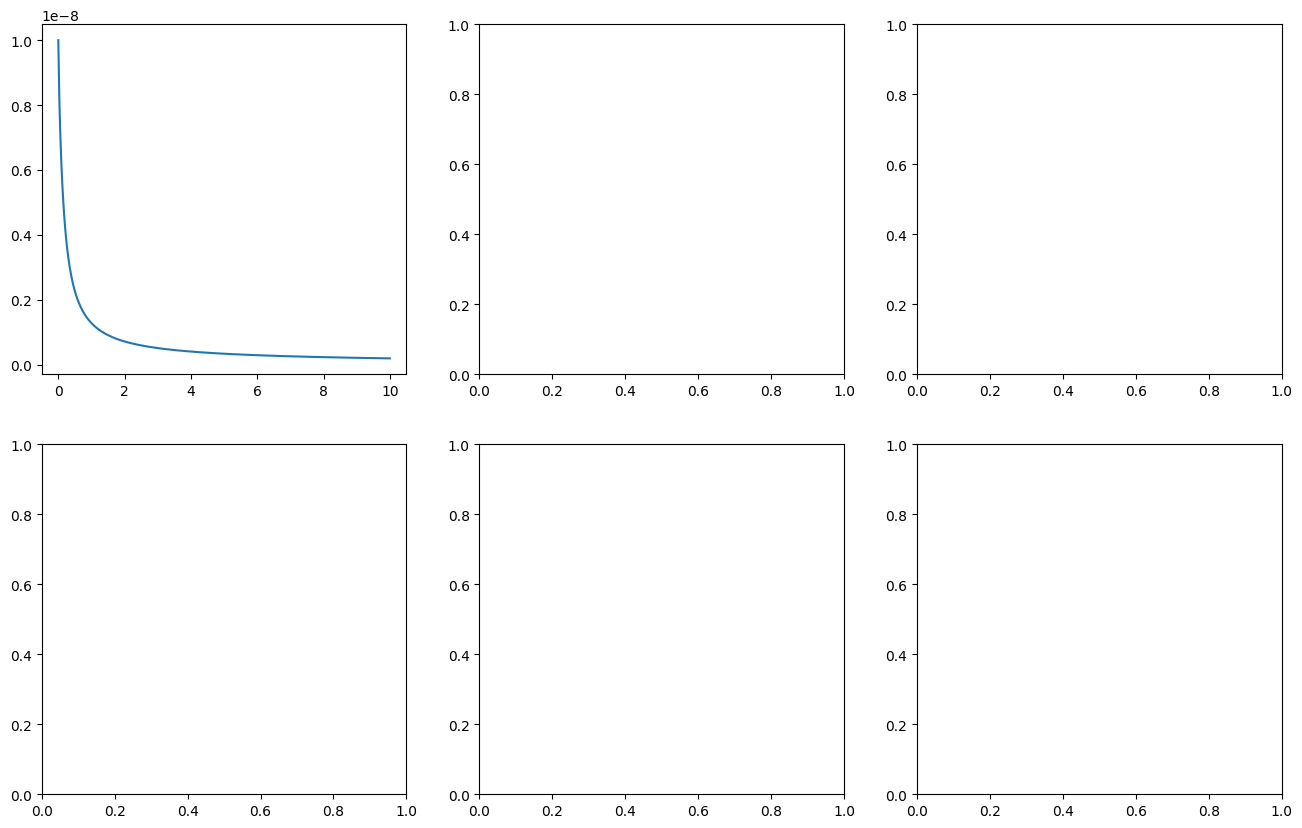

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for i in range(6):
    ax[i // 3, i % 3].plot(t_train, X[:, i], label=f'X{i+1}')
    ax[i // 3, i % 3].plot(t_train, x_sim[:, i], label=f'X{i+1} Simulated', linestyle='--')
    ax[i // 3, i % 3].set_title(f'X{i+1}')
    ax[i // 3, i % 3].legend()